In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts
import os
import ffn

In [62]:
TUSHARE_API_KEY = os.environ.get('TUSHARE_API_KEY')
ts_pro = ts.pro_api(TUSHARE_API_KEY)

# 获取股票数据
df = ts_pro.daily(ts_code='600025.SH', start_date='20240514', end_date='20250513', fields='ts_code,trade_date,open,high,low,close,vol')
df.sort_values(by='trade_date', ascending=True, inplace=True) # 确保按时间升序排列
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.to_csv('data/600025.SH.csv', index=False)

# 读取历史数据
df = pd.read_csv('data/600025.SH.csv')
df['MA5'] = df['close'].rolling(window=5).mean()
df['MA10'] = df['close'].rolling(window=10).mean()
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA60'] = df['close'].rolling(window=60).mean()

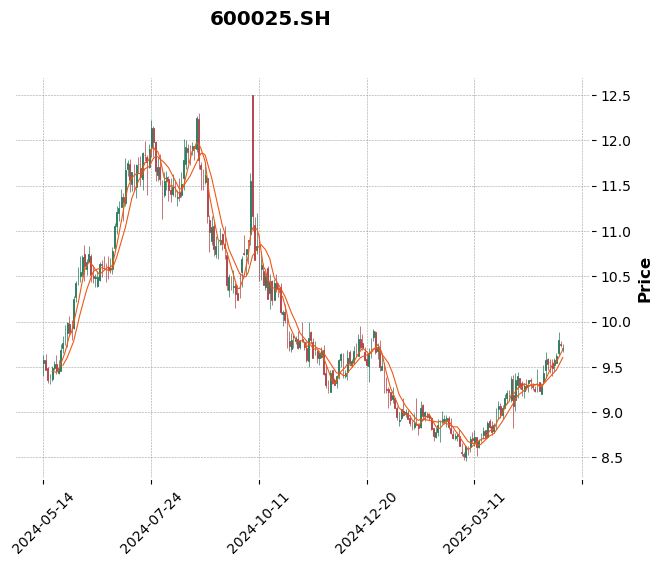

In [60]:
import mplfinance as mpf
df_plot = df.copy()
df_plot
df_plot['trade_date'] = pd.to_datetime(df_plot['trade_date'])
df_plot.set_index('trade_date', inplace=True)

df_plot.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'vol': 'Volume'}, inplace=True)

mpf.plot(df_plot, type='candle', style='charles', datetime_format='%Y-%m-%d', title='600025.SH', mav=(5, 10))

In [72]:
# 初始化变量
hold = False # 是否持仓
pos = 0 # 持仓数
cash = 100000 # 初始资金
fee = 0.0003 # 手续费万三
capital_list = [] # 每日资金数列表

for index, row in df.iterrows():
    current_date = row['trade_date']
    price = row['close']
    ma10 = row['MA10']
    ma20 = row['MA20']

    # 跳过无均线的初期阶段
    if pd.isna(ma10) or pd.isna(ma20):
        capital_list.append(cash + pos * price) # 记录总资产
        continue
    
    # 交易信号逻辑
    if ma10 >= ma20 and not hold:
        # 计算可买数量（按100股整数倍）
        max_shares = int(cash / (price * (1 + fee)))
        pos = (max_shares // 100) * 100
        if pos > 0:
            cost = pos * price * (1 + fee)
            cash -= cost
            hold = True
            print(f'Buy at {current_date}, price {price:.2f}, pos {pos}')
    elif ma10 < ma20 and hold:
        
        # 平仓全部头寸
        proceeds = pos * price * (1 - fee)
        cash += proceeds
        pos = 0
        hold = False
        print(f'Sell at {current_date}, price {price:.2f}, proceeds {proceeds:.2f}')
    
    # 记录每日总资产
    capital_list.append(cash + pos * price)

Buy at 2024-06-11, price 10.61, pos 9400
Sell at 2024-08-06, price 11.41, proceeds 107221.82
Buy at 2024-08-20, price 11.94, pos 8900
Sell at 2024-09-02, price 11.04, proceeds 98226.52
Buy at 2024-10-09, price 10.68, pos 9300
Sell at 2024-10-21, price 10.24, proceeds 95203.43
Buy at 2024-12-12, price 9.67, pos 9800
Sell at 2025-01-03, price 9.24, proceeds 90524.83
Buy at 2025-03-19, price 8.88, pos 10200


In [73]:
capital_series = pd.Series(capital_list)

# 计算关键指标
print("总收益率:", ffn.calc_total_return(capital_series))
print("最大回撤:", ffn.calc_max_drawdown(capital_series))
print("夏普比例:", ffn.calc_sharpe(capital_series))

总收益率: -0.00594588000000007
最大回撤: -0.2136617702339334
夏普比例: 16.552517337641365


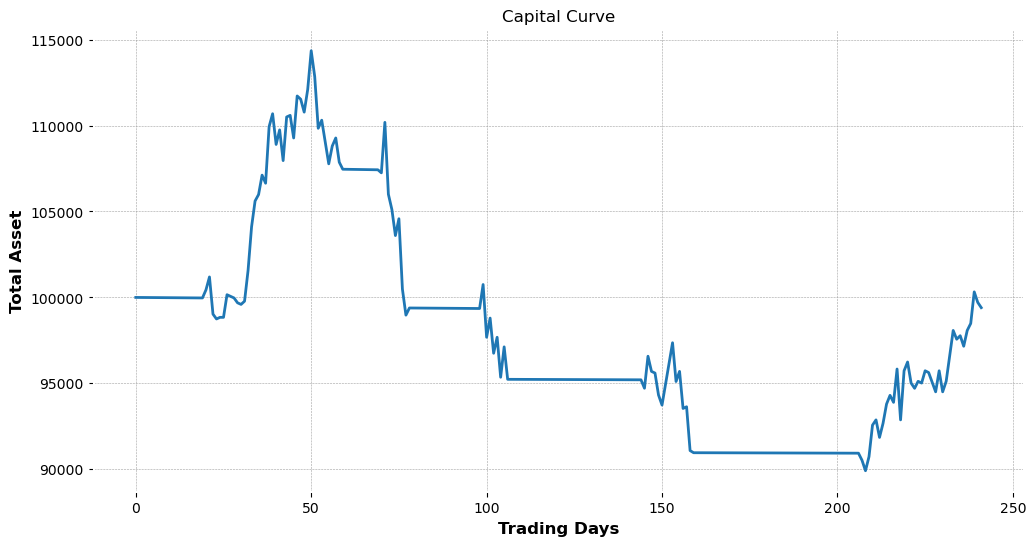

In [74]:
# 可视化资金曲线
plt.figure(figsize=(12,6))
plt.plot(capital_series)
plt.title('Capital Curve')
plt.ylabel('Total Asset')
plt.xlabel('Trading Days')
plt.grid(True)
plt.show()

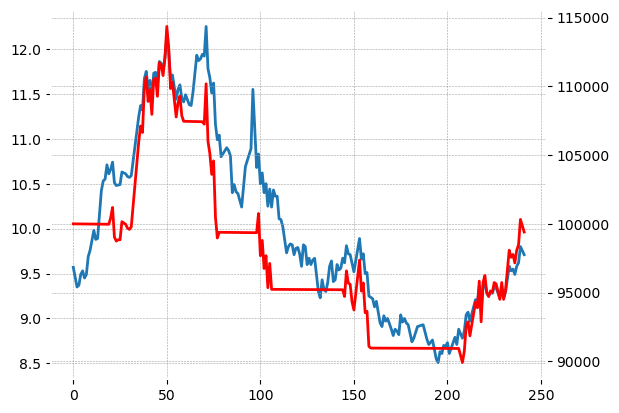

In [75]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df['close'], label='Price')
ax2.plot(capital_series, 'r-', label='Capital')